##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 图像分割

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-321ut010
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-321ut010
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=d00adbab79ea29f39b1177b79d5b28001d3772e412b8b6ddf75953499685f869
  Stored in directory: /tmp/pip-ephem-wheel-cache-25xny1wv/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf
import os
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras import layers

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from tensorflow import TensorSpec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# 輸入資料集路徑
#custom_dir = input("請貼上你的資料集資料夾完整路徑（如 /content/drive/MyDrive/...）：\n")

# 確認資料夾存在
# if not os.path.isdir(custom_dir):
#     raise FileNotFoundError(f"找不到資料夾：{custom_dir}，請確認路徑拼寫正確並已掛載雲端硬碟！")

#BASE_DIR = custom_dir
BASE_DIR = '/content/drive/MyDrive/機器學習/ETT data'
print(f"資料夾設定成功：{BASE_DIR}")


# 超參數
IMG_SIZE   = 256
BATCH_SIZE = 8
AUTOTUNE   = tf.data.AUTOTUNE
NUM_CLASSES = 3
NUM_FOLDS  = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive
資料夾設定成功：/content/drive/MyDrive/機器學習/ETT data


In [ ]:
# 圖片增強函數
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

augment_layer = Augment(seed=123)

In [ ]:
# 讀檔 + normalize
def load_and_normalize(image_path, mask_path):
  """
  讀取單張影像與遮罩
  img_path  : tf.string，影像檔路徑
  mask_path : tf.string，遮罩檔路徑
  return    : (image, mask)；image 為 float32、mask 為 int32
  """
  # 讀影像
  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img = tf.cast(img, tf.float32) / 255.0

  # 讀遮罩（假設單通道 png，像素值=類別 ID）
  msk = tf.io.read_file(mask_path)
  msk = tf.image.decode_png(msk, channels=1)
  msk = tf.image.resize(msk, [IMG_SIZE, IMG_SIZE], method="nearest")
  msk = tf.cast(msk, tf.int32)  # 確保是整數型

  return img, msk

In [ ]:
def parse_image_mask(image_path, mask_path):
    # 圖片處理
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)           # RGB
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0               # 正規化到 [0,1]

    # 遮罩處理
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)             # 灰階單通道
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    mask = tf.cast(mask, tf.float32) * 255.0                 # 還原到 [0, 255]

    # 將所有非 0 的 pixel 當作前景（氣管內管）
    mask = tf.where(mask > 0, 1.0, 0.0)    # 產生 0.0 / 1.0
    mask = tf.cast(mask, tf.float32)      # 確保 float32
    return image, mask


def augment(image, mask):
    mask = tf.cast(mask, tf.float32)  # ✨ 統一型別，跟 image 一樣
    stacked = tf.concat([image, mask], axis=-1)   # shape=(H,W,4)
    flipped = tf.image.random_flip_left_right(stacked)
    image_aug = flipped[..., :3]
    mask_aug  = flipped[..., 3:]
    return image_aug, mask_aug

def build_dataset(image_dir, mask_dir, augment_data=False):
    img_paths  = sorted([f"{image_dir}/{f}" for f in tf.io.gfile.listdir(image_dir)])
    mask_paths = sorted([f"{mask_dir}/{f}"  for f in tf.io.gfile.listdir(mask_dir)])

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda i, m: parse_image_mask(i, m), num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(lambda i, m: augment(i, m), num_parallel_calls=AUTOTUNE)

    return ds

呈现数据集中的图像样本及其对应的掩码：

In [ ]:
def plot_batch(image_batch, mask_batch, count=3):
    for i in range(min(count, image_batch.shape[0])):
        image = image_batch[i]
        mask  = mask_batch[i]

        # 調整 image 的顯示格式
        image = tf.cast(image, tf.float32)
        if tf.reduce_max(image) <= 1.0:
            image = image * 255.0
        image = tf.clip_by_value(image, 0, 255)
        image = tf.cast(image, tf.uint8)

        # squeeze 掉 mask 的通道
        if mask.ndim == 3:
            mask = tf.squeeze(mask, axis=-1)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(image.numpy())
        axs[0].set_title("Image")

        axs[1].imshow(mask.numpy(), cmap='gray')
        axs[1].set_title("Ground Truth")

        axs[2].imshow(mask.numpy(), cmap='gray')
        axs[2].set_title("Prediction (same as mask)")

        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

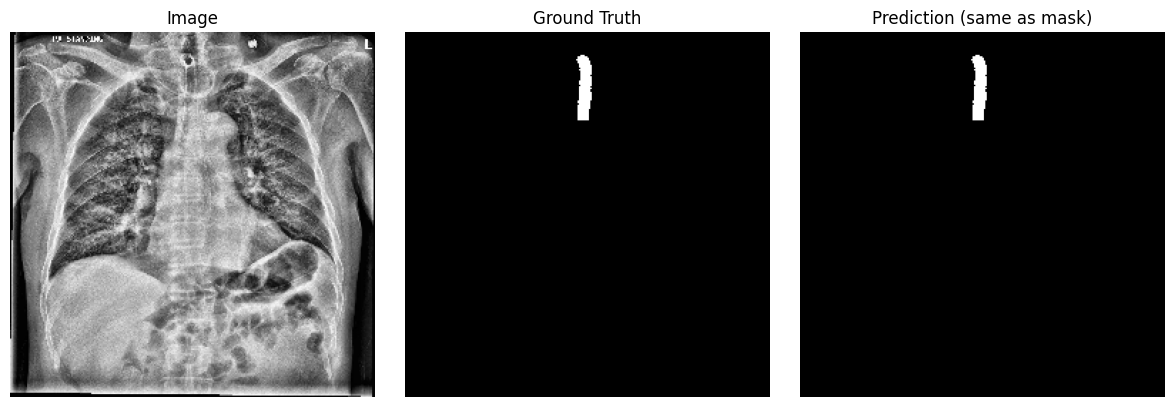

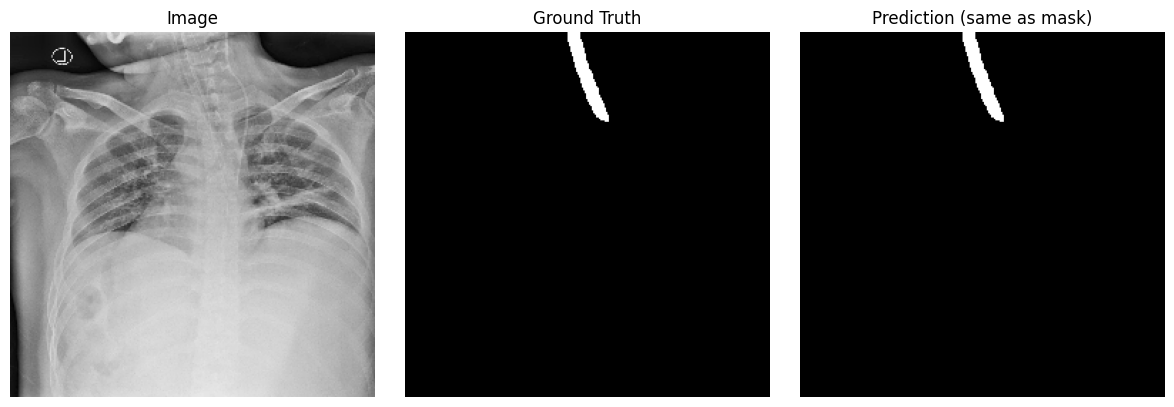

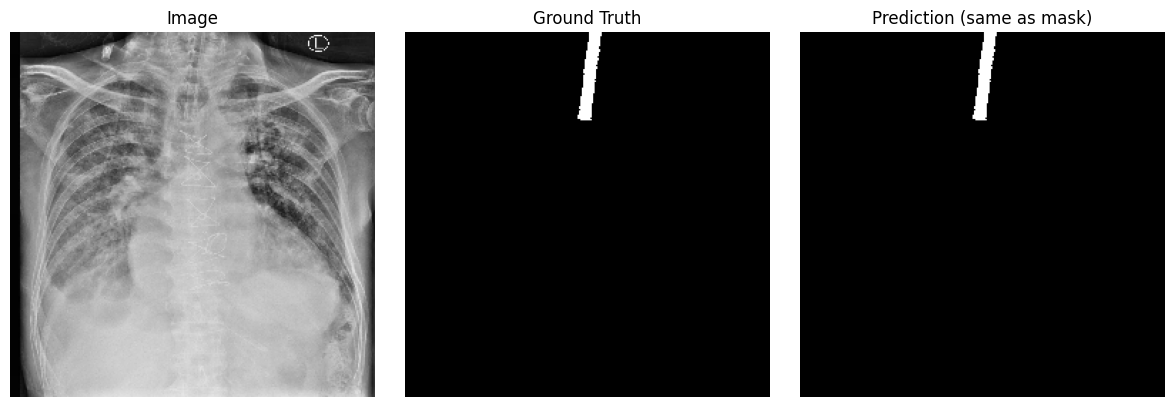

In [ ]:
train_ds= build_dataset(f"{BASE_DIR}/Fold{1}/train",
                             f"{BASE_DIR}/Fold{1}/trainannot",
                             augment_data=True).batch(BATCH_SIZE)
for image_batch, mask_batch in train_ds.take(1):  # 抓一個 batch
    plot_batch(image_batch, mask_batch, count=3)  # 顯示前三張圖

## 建立模型

解码器/上采样器只是在 TensorFlow 示例中实现的一系列上采样块：

In [ ]:
def atrous_spatial_pyramid_pooling(inputs, dilation_rates=[6, 12, 18]):
    pooled = []
    pooled.append(layers.Conv2D(256, 1, padding='same', activation='relu')(inputs))
    for rate in dilation_rates:
        pooled.append(layers.Conv2D(256, 3, padding='same', dilation_rate=rate, activation='relu')(inputs))
    avg = layers.GlobalAveragePooling2D()(inputs)
    avg = layers.Reshape((1, 1, inputs.shape[-1]))(avg)
    avg = layers.Conv2D(256, 1, padding='same', activation='relu')(avg)
    # 將平均池化結果放大到與 inputs 等同尺寸
    avg = layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation='bilinear')(avg)
    pooled.append(avg)
    x = layers.Concatenate()(pooled)
    return layers.Conv2D(256, 1, padding='same', activation='relu')(x)

# DeepLab v3+ 取代 U-Net
def deeplab_model(input_shape=(256, 256, 3), num_classes=1):
    """
    建立 DeepLab v3+ 模型
    input_shape: (H, W, C)，建議 H, W 為 224 或 256
    num_classes: 輸出分割類別數
    """
    # Backbone: MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    layer_names = [
        'block_1_expand_relu',   # 128x128 或 位置依 input_shape 而定
        'block_3_expand_relu',   # 64x64
        'block_6_expand_relu',   # 32x32
        'block_13_expand_relu',  # 16x16
        'block_16_project',      # 8x8
    ]
    down_stack = tf.keras.Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer(name).output for name in layer_names]
    )
    down_stack.trainable = False

    # 構建模型
    inputs = tf.keras.Input(shape=input_shape)
    skips = down_stack(inputs)
    high_level = skips[-1]      # 最深層特徵，空間尺寸 H/32, W/32
    low_level = skips[1]        # 中階特徵，空間尺寸 H/4, W/4 (64x64)

    # ASPP
    x = atrous_spatial_pyramid_pooling(high_level)

    # Decoder: 將 ASPP 輸出先 resize 回 low_level 同尺寸
    x = layers.Resizing(low_level.shape[1], low_level.shape[2], interpolation='bilinear')(x)
    low = layers.Conv2D(48, 1, padding='same', activation='relu')(low_level)
    x = layers.Concatenate()([x, low])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    # 最終 resize 回原始解析度
    x = layers.Resizing(input_shape[0], input_shape[1], interpolation='bilinear')(x)
    outputs = layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# 全域宣告：1 公分 = 72 像素
P = 72.0

class MeanErrorCM(tf.keras.metrics.Metric):
    def __init__(self, name='mean_error_cm', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_error = self.add_weight(name='total_error', initializer='zeros')
        self.count       = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # 先把 y_true 轉成 float32
        y_true = tf.cast(y_true, y_pred.dtype)
        # 像素誤差 ÷ P → 公分誤差
        error_px = tf.abs(y_true - y_pred)
        error_cm = error_px / P
        self.total_error.assign_add(tf.reduce_sum(error_cm))
        self.count.assign_add(tf.cast(tf.size(error_cm), tf.float32))

    def result(self):
        return self.total_error / (self.count + 1e-8)

    def reset_states(self):
        self.total_error.assign(0.)
        self.count.assign(0.)


class AccuracyWithinThreshold(tf.keras.metrics.Metric):
    def __init__(self, threshold_cm=0.5, name='acc_within_threshold', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold_cm = threshold_cm
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total   = self.add_weight(name='total', initializer='zeros')

    def _extract_endpoint(self, mask):
      mask = tf.squeeze(mask, axis=-1)
      mask = tf.cast(mask, tf.float32)
      # 加入一個中繼張量，然後 cast 成 int32
      raw_indices = tf.where(mask > 0.5)
      indices     = tf.cast(raw_indices, tf.int32)

      def no_fg():
          return tf.constant([-1.0, -1.0], dtype=tf.float32)

      def has_fg():
          # indices[:,0] 代表 y 座標
          # output_type 直接指定為 tf.int32
          max_y_idx = tf.argmax(indices[:, 0], output_type=tf.int32)

          # 取出 (x, y) 並轉成 float32
          endpoint = tf.cast(indices[max_y_idx][::-1], tf.float32)
          return endpoint

      return tf.cond(tf.shape(indices)[0] == 0, no_fg, has_fg)


    def update_state(self, y_true, y_pred, sample_weight=None):
        def compute_sample_accuracy(args):
            gt_mask, pred_mask = args
            gt_point = self._extract_endpoint(gt_mask)
            pred_point = self._extract_endpoint(pred_mask)

            # 判斷是否為有效點（不是 [-1, -1]）
            is_valid = tf.reduce_all(gt_point >= 0) & tf.reduce_all(pred_point >= 0)

            def compute_accuracy():
                err_px = tf.norm(gt_point - pred_point)
                err_cm = err_px / P
                return tf.cast(err_cm <= self.threshold_cm, tf.float32)

            return tf.cond(is_valid, compute_accuracy, lambda: tf.constant(-1.0))  # 無效標記為 -1

        correctness_batch = tf.map_fn(
          compute_sample_accuracy,
          (y_true, y_pred),
          fn_output_signature=TensorSpec(shape=(), dtype=tf.float32)
        )

        # 過濾掉無效樣本（== -1）
        # 直接過濾出 >= 0 的項目
        valid_values = tf.boolean_mask(correctness_batch, correctness_batch >= 0.0)

        self.correct.assign_add(tf.reduce_sum(valid_values))
        self.total.assign_add(tf.cast(tf.shape(valid_values)[0], tf.float32))

    def result(self):
        return self.correct / (self.total + 1e-8)

    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# 1. 建立一個 callback，專門拆 MeanIoU 的結果
class PerClassIoUCallback(tf.keras.callbacks.Callback):
    def __init__(self, mean_iou_metric):
        super().__init__()
        self.mean_iou = mean_iou_metric

    def on_epoch_begin(self, epoch, logs=None):
      # 清掉上一次累積的 confusion matrix
      self.mean_iou.reset_state()


    def on_epoch_end(self, epoch, logs=None):
        conf_matrix = self.mean_iou.total_cm.numpy()
        inter      = np.diag(conf_matrix)            # [conf[0,0], conf[1,1]]
        gt_sum     = conf_matrix.sum(axis=1)          # 每行：真實各類總數
        pred_sum   = conf_matrix.sum(axis=0)          # 每列：預測各類總數
        union      = gt_sum + pred_sum - inter
        per_iou    = inter / (union + 1e-8)

        print(f"\nEpoch {epoch+1} per-class IoU:")
        print(f"  - 背景 (0) IoU: {per_iou[0]:.4f}")
        print(f"  - 前景 (1) IoU: {per_iou[1]:.4f}")

In [ ]:
class BinarizedIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.int32)
        y_true = tf.cast(y_true, tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
OUTPUT_CLASSES = 2

model = deeplab_model()
# 定義 MeanIoU、平均誤差公分、誤差在0.5cm內準確率、誤差在1.0cm內準確率
iou_metric = BinarizedIoU(num_classes=2, name='mean_iou')
mean_error = MeanErrorCM(name='mean_error_cm')
acc_0_5cm = AccuracyWithinThreshold(0.5, name='acc_within_0.5cm')
acc_1_0cm = AccuracyWithinThreshold(1.0, name='acc_within_1.0cm')

metrics   = [iou_metric, mean_error, acc_0_5cm, acc_1_0cm]

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss='binary_crossentropy',
  metrics=metrics,
  run_eagerly=True
)

<ipython-input-10-f914859ba65b>:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


绘制最终的模型架构：

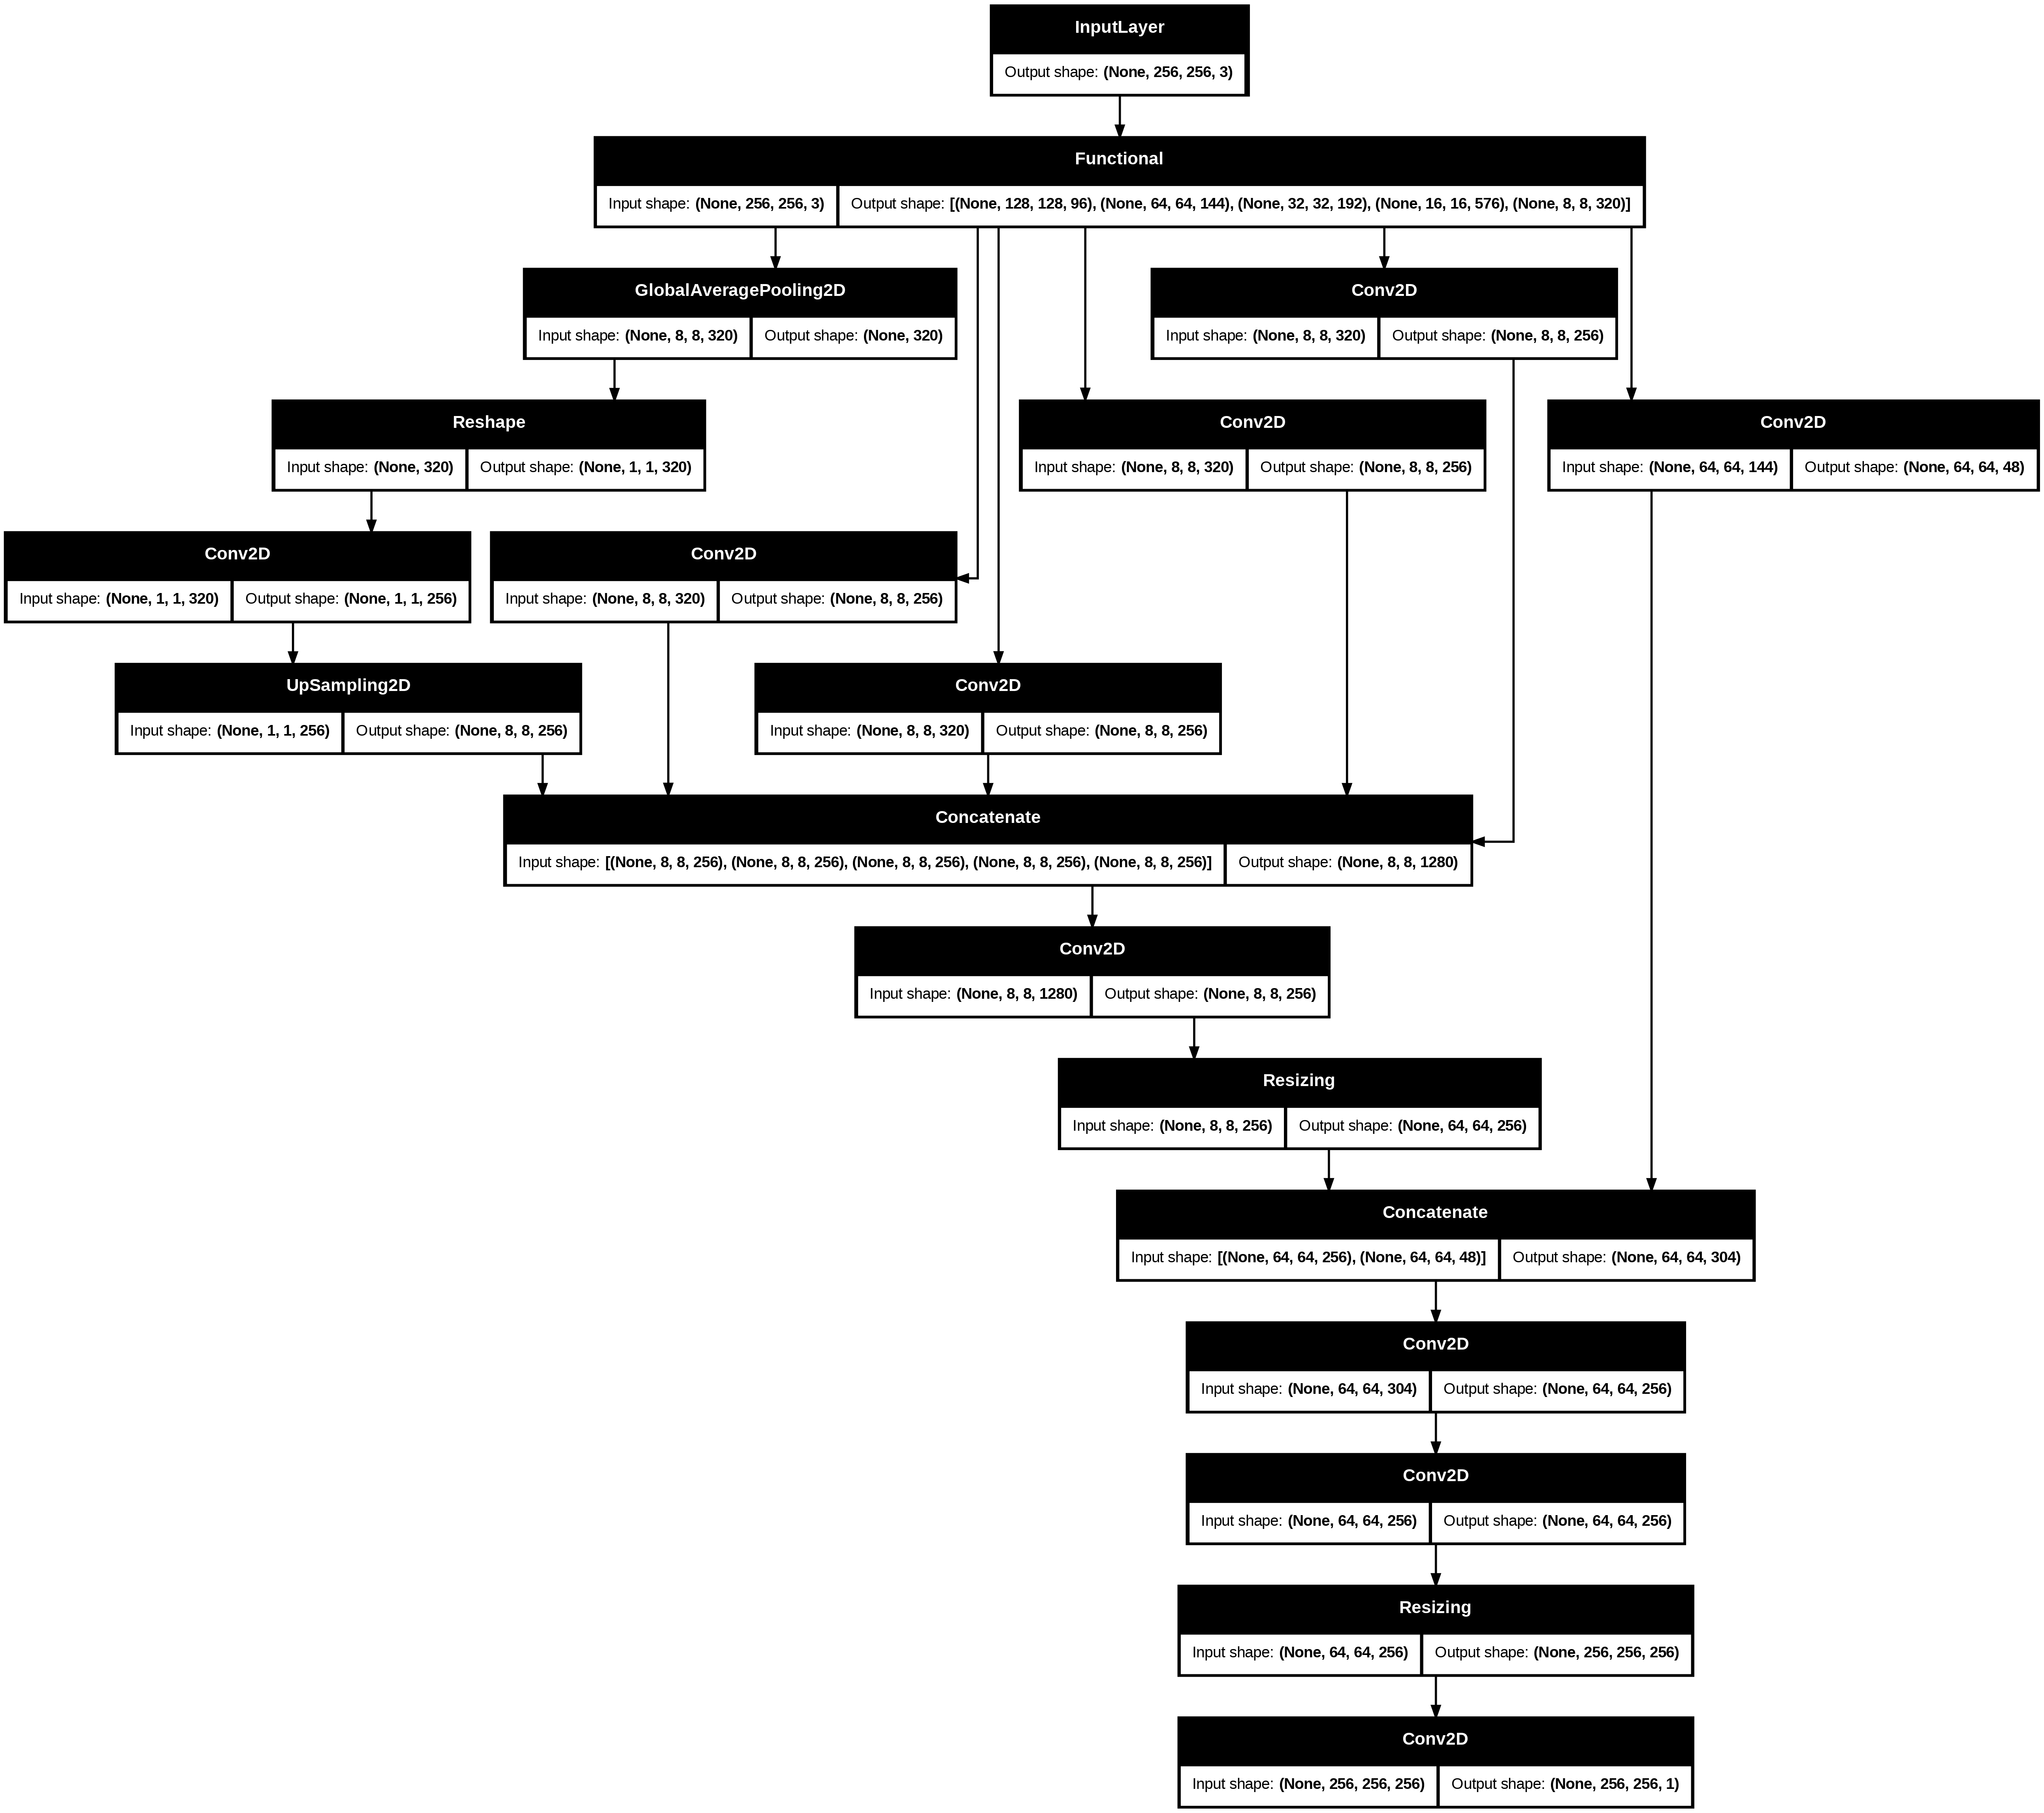

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 訓練模型

In [ ]:
EPOCHS = 5
history_list = []  # 用來儲存每一折的訓練歷史

for fold in range(1, NUM_FOLDS + 1):
    print(f"\n===== Fold {fold} / {NUM_FOLDS} =====")

    val_ds = build_dataset(f"{BASE_DIR}/Fold{fold}/val",
                           f"{BASE_DIR}/Fold{fold}/valannot",
                           augment_data=False)

    train_ds = None
    for k in range(1, NUM_FOLDS + 1):
        if k == fold:
            continue
        ds_k = build_dataset(f"{BASE_DIR}/Fold{k}/train",
                             f"{BASE_DIR}/Fold{k}/trainannot",
                             augment_data=True)
        train_ds = ds_k if train_ds is None else train_ds.concatenate(ds_k)

    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    val_ds   = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    callbacks = [
      EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
      ModelCheckpoint(filepath=f"best_model_fold{fold}.weights.h5",
                      monitor='val_loss',
                      save_best_only=True,
                      save_weights_only=True),
      PerClassIoUCallback(iou_metric),
    ]

    # 開始訓練並儲存該折的 history
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=EPOCHS,
      callbacks=callbacks
    )
    history_list.append(history)  # <=== 儲存每一折的 history


===== Fold 1 / 5 =====
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - acc_within_0.5cm: 0.2726 - acc_within_1.0cm: 0.5466 - loss: 0.0658 - mean_error_cm: 4.4290e-04 - mean_iou: 0.5133
Epoch 1 per-class IoU:
  - 背景 (0) IoU: 0.9928
  - 前景 (1) IoU: 0.2450
143/143 ━━━━━━━━━━━━━━━━━━━━ 205s 632ms/step - acc_within_0.5cm: 0.2756 - acc_within_1.0cm: 0.5495 - loss: 0.0656 - mean_error_cm: 4.4161e-04 - mean_iou: 0.5137 - val_acc_within_0.5cm: 0.9318 - val_acc_within_1.0cm: 1.0000 - val_loss: 0.0183 - val_mean_error_cm: 1.2400e-04 - val_mean_iou: 0.6189
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - acc_within_0.5cm: 0.9213 - acc_within_1.0cm: 0.9970 - loss: 0.0184 - mean_error_cm: 1.5277e-04 - mean_iou: 0.7077
Epoch 2 per-class IoU:
  - 背景 (0) IoU: 0.9941
  - 前景 (1) IoU: 0.4445
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 609ms/step - acc_within_0.5cm: 0.9215 - acc_within_1.0cm: 0.9970 - loss: 0.0184 - mean_error_cm: 1.5273e-04 - mean_iou: 0.7078 - val_acc_within_0.5cm: 1.0000 - val_acc_wi

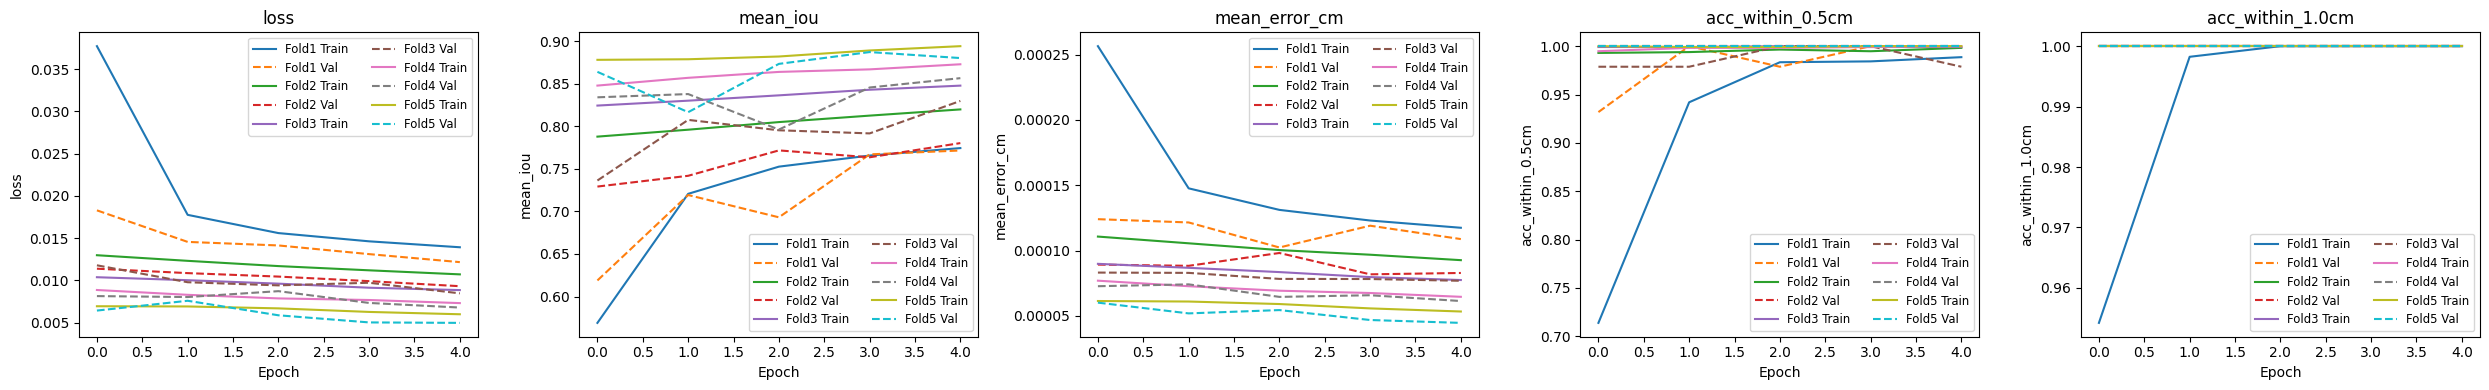

In [ ]:
metrics = ['loss','mean_iou', 'mean_error_cm', 'acc_within_0.5cm', 'acc_within_1.0cm']

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(metrics),
    figsize=(5 * len(metrics), 4)
)

for ax, m in zip(axes, metrics):
    for fold_idx, h in enumerate(history_list, start=1):
        train_vals = h.history[m]              # 該折的訓練指標
        val_vals   = h.history[f'val_{m}']     # 該折的驗證指標

        # 一條實線和一條虛線，分別代表訓練和驗證
        ax.plot(h.epoch, train_vals,  label=f'Fold{fold_idx} Train')
        ax.plot(h.epoch, val_vals,   '--', label=f'Fold{fold_idx} Val')

    ax.set_title(m)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(m)
    ax.legend(fontsize='small', ncol=2)  # 讓圖例分兩行顯示，不至於擠在一起

plt.tight_layout()
plt.show()

## 做出预测

In [ ]:
def extract_endpoint_np(mask_np):
    """
    取最靠近病人腳端 (y 最大) 的前景像素座標。
    mask_np : (H,W) or (H,W,1) ndarray, 值 0 / 1
    回傳   : (x, y)；若無前景 → (-1,-1)
    """
    if mask_np.ndim == 3:
        mask_np = mask_np.squeeze(-1)

    ys, xs = tf.where(mask_np > 0.5).numpy().T
    if len(ys) == 0:
        return (-1, -1)

    idx = ys.argmax()          # y 最大
    return (int(xs[idx]), int(ys[idx]))


In [ ]:
def plot_batch_with_preds(image_batch, mask_batch, model, count=3):
    """
    顯示 [Image / Ground-Truth / Prediction]，並把
    - 綠色圓點標 GT 端點
    - 紅色叉叉標 Pred 端點
    """
    # 1. 預測 + 二值化
    preds = tf.where(model.predict(image_batch) >= 0.5, 1, 0)

    for i in range(min(count, image_batch.shape[0])):
        img  = image_batch[i]
        gt   = mask_batch[i]
        prd  = preds[i]

        # 還原影像亮度
        if tf.reduce_max(img) <= 1.0:
            img = tf.cast(img * 255.0, tf.uint8)
        else:
            img = tf.cast(img, tf.uint8)

        # 去掉 channel
        if gt.ndim == 3: gt  = tf.squeeze(gt,  axis=-1)
        if prd.ndim == 3: prd = tf.squeeze(prd, axis=-1)

        # 端點
        gt_pt  = extract_endpoint_np(gt.numpy())
        prd_pt = extract_endpoint_np(prd.numpy())

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        # ------------ Image ------------
        axs[0].imshow(img.numpy())
        if gt_pt != (-1, -1):
            axs[0].scatter(*gt_pt, s=60, c='lime', marker='o', label='GT')
        if prd_pt != (-1, -1):
            axs[0].scatter(*prd_pt, s=60, c='red',  marker='x', label='Pred')
        axs[0].set_title("Image + Endpoints")
        axs[0].axis("off")
        axs[0].legend(loc='lower right', fontsize='small')

        # ------------ GT mask ------------
        axs[1].imshow(gt.numpy(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")

        # ------------ Pred mask ------------
        axs[2].imshow(prd.numpy(), cmap='gray')
        axs[2].set_title("Prediction")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

In [ ]:
test_ds = build_dataset(f"{BASE_DIR}/Fold{1}/test",
                             f"{BASE_DIR}/Fold{1}/testannot",
                             augment_data=False).batch(BATCH_SIZE)
for image_batch, mask_batch in train_ds.take(1):
    plot_batch_with_preds(image_batch, mask_batch, model, count=3)

NameError: name 'build_dataset' is not defined